<a href="https://colab.research.google.com/github/mayorofdata/Lab-5/blob/master/language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from fastai.text import *

path = "/content/drive/My Drive/DATA-475/imdb"

In [3]:
# create TextLMDataBunch using the csv in path
#     remember to specify the text column
data_lm = TextLMDataBunch.from_csv(
    path,
    "train.csv",
    text_cols="review"
)

In [4]:
# create TextClasDataBunch using the csv in path
#     remember to specify the text/label column
#     specify test dataset, vocab, and bs
data_clas = TextClasDataBunch.from_csv(
    path,
    "train.csv",
    test="test.csv",
    text_cols="review",
    label_cols="sentiment",
    vocab=data_lm.train_ds.vocab,
    bs=32,
)

In [5]:
# create language model learner with AWD_LSTM architecture and drop_mult of 0.5
lm_learner = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-03


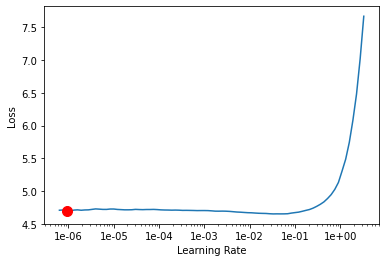

In [6]:
# find a learing rate
lm_learner.lr_find()
lm_learner.recorder.plot(suggestion=True)

In [7]:
# fit one cycle
lr = lm_learner.recorder.min_grad_lr
lm_learner.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.685271,4.482455,0.262578,14:44
1,4.673829,4.480662,0.262765,14:45


In [8]:
# save the encoder
lm_learner.save_encoder("model")

In [9]:
lm_learner.predict("this movie talks about Canadian", n_words=20)

'this movie talks about Canadian shark attacks in 1962 , inflicts ( 1979 ) , and 1977 ( 1981 ) . Schneider explained that'

In [10]:
clas_learner = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
clas_learner.load_encoder("model")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19999 items)
x: TextList
xxbos xxup wow ! xxmaj what - a - movie xxrep 11 ! i 'm not at all a fan of contemporary xxmaj italian directors . xxmaj usually i do n't like dramas . i am not a xxmaj will xxmaj smith super fan even thinking that he is a very good actor xxrep 6 . but this movie ! xxmaj it is such a great movie with a such original script and so good direction and so well acting ... wow ... it is stunning . xxmaj this movie captured my attention minute by minute and i even did not like " xxmaj the pursuit of happiness " ( maybe also because i did not like the acting of xxmaj will 's son who is a very bad actor while children usually seems all natural born actors , i saw him also last night in " xxmaj the day the earth stood still " and i confirmed my sensation that xxmaj xxunk ca n't act ) . i do n't want to write spoilers and so i do n't talk about the story but what i can say is that this movie talks about xxmaj love , xx

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.45E-02


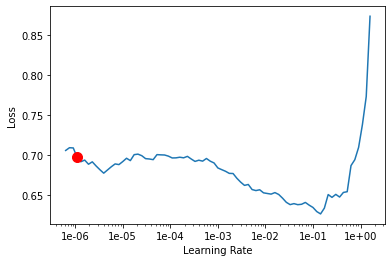

In [11]:
# tune the text_classifier_learner to accpetable accuracy (>80%)
clas_learner.lr_find()
clas_learner.recorder.plot(suggestion=True)
# lr = clas_learner.recorder.min_grad_lr
# clas_learner.fit_one_cycle(4, lr)

In [12]:
lr = clas_learner.recorder.min_grad_lr
clas_learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.724716,0.679988,0.580084,06:19
1,0.703891,0.661327,0.604279,07:27
2,0.687333,0.643130,0.624675,07:02
3,0.682920,0.641488,0.623275,07:34


In [13]:
clas_learner.predict("This is a horrible movie")

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


(Category tensor(0), tensor(0), tensor([0.6287, 0.3713]))

In [14]:
clas_learner.predict("This is a great movie,")

(Category tensor(1), tensor(1), tensor([0.2115, 0.7885]))

In [15]:
# Check the label mapping
# suppose it returns {'negative': 0, 'positive': 1}
data_clas.train_ds.y.c2i

{'negative': 0, 'positive': 1}

In [16]:
import pandas as pd


df = pd.read_csv(path+"/test.csv")
y_true = tensor(df["sentiment"]=="positive")

In [17]:
y_true

tensor([ True,  True,  True,  ..., False, False, False])

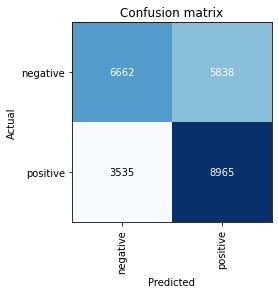

In [18]:
interp = TextClassificationInterpretation.from_learner(
    clas_learner, 
    ds_type=DatasetType.Test
)
interp.y_true = tensor(df["sentiment"]=="positive")
interp.plot_confusion_matrix()

In [19]:
from fastai.metrics import accuracy

accuracy(interp.preds, interp.y_true)

tensor(0.6251)